### Superpixel creation and extraction of superpixel intensity, order and co-ordinates.


In [ ]:
# Compute superpixels for MNIST/CIFAR-10 using SLIC algorithm
# https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

In [34]:
import numpy as np
import random
import os
import scipy
import pickle
from skimage.segmentation import slic
from torchvision import datasets
import multiprocessing as mp
import scipy.ndimage
import scipy.spatial
import argparse
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.segmentation import slic, mark_boundaries
from skimage import graph,data,segmentation,color,future
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage import draw, future

def parse_args():
    parser = argparse.ArgumentParser(description='Extract SLIC superpixels from images')
    parser.add_argument('-D', '--dataset', type=str, default='mnist', choices=['mnist', 'cifar10'])
    parser.add_argument('-d', '--data_dir', type=str, default='./data', help='path to the dataset')
    parser.add_argument('-o', '--out_dir', type=str, default='./data', help='path where to save superpixels')
    parser.add_argument('-s', '--split', type=str, default='train', choices=['train', 'val', 'test'])
    parser.add_argument('-t', '--threads', type=int, default=0, help='number of parallel threads')
    parser.add_argument('-n', '--n_sp', type=int, default=75, help='max number of superpixels per image')
    parser.add_argument('-c', '--compactness', type=int, default=0.25, help='compactness of the SLIC algorithm '
                                                                      '(Balances color proximity and space proximity): '
                                                                      '0.25 is a good value for MNIST '
                                                                      'and 10 for color images like CIFAR-10')
    parser.add_argument('--seed', type=int, default=111, help='seed for shuffling nodes')
    args,unknown = parser.parse_known_args() #changed args = parser.parse_args()

    for arg in vars(args):
        print(arg, getattr(args, arg))

    return args

def show_image(image):
  width = 10
  height = image.shape[0] * width / image.shape[1]
  f = plt.figure(figsize=(width,height))
  plt.imshow(image,cmap='gray')


In [25]:
def process_image(params):
    
    img, index, n_images, args, to_print, shuffle = params

    assert img.dtype == np.uint8, img.dtype
    img = (img / 255.).astype(np.double)

    n_sp_extracted = args.n_sp + 1  # number of actually extracted superpixels (can be different from requested in SLIC)
    n_sp_query = args.n_sp + (20 if args.dataset == 'mnist' else 50)  # number of superpixels we ask to extract (larger to extract more superpixels - closer to the desired n_sp)
    while n_sp_extracted > args.n_sp:
        superpixels = slic(img, n_segments=n_sp_query, compactness=args.compactness, multichannel=len(img.shape) > 2)
        sp_indices = np.unique(superpixels)
        n_sp_extracted = len(sp_indices)
        n_sp_query -= 1  # reducing the number of superpixels until we get <= n superpixels

    assert n_sp_extracted <= args.n_sp and n_sp_extracted > 0, (args.split, index, n_sp_extracted, args.n_sp)
    assert n_sp_extracted == np.max(superpixels) + 1, ('superpixel indices', np.unique(superpixels))  # make sure superpixel indices are numbers from 0 to n-1

    if shuffle:
        ind = np.random.permutation(n_sp_extracted)
    else:
        ind = np.arange(n_sp_extracted)

    sp_order = sp_indices[ind].astype(np.int32)
    if len(img.shape) == 2:
        img = img[:, :, None]

    n_ch = 1 if img.shape[2] == 1 else 3

    sp_intensity, sp_coord = [], []
    for seg in sp_order:
        mask = (superpixels == seg).squeeze()
        avg_value = np.zeros(n_ch)
        for c in range(n_ch):
            avg_value[c] = np.mean(img[:, :, c][mask])
        cntr = np.array(scipy.ndimage.measurements.center_of_mass(mask))  # row, col
        sp_intensity.append(avg_value)
        sp_coord.append(cntr)
    sp_intensity = np.array(sp_intensity, np.float32)
    sp_coord = np.array(sp_coord, np.float32)
    if to_print:
        print('image={}/{}, shape={}, min={:.2f}, max={:.2f}, n_sp={}'.format(index + 1, n_images, img.shape,
                                                                              img.min(), img.max(), sp_intensity.shape[0]))

    return sp_intensity, sp_coord, sp_order, superpixels




In [26]:
dt = datetime.datetime.now()
print('start time:', dt)

args = parse_args()

if not os.path.isdir(args.out_dir):
        os.mkdir(args.out_dir)

random.seed(args.seed)
np.random.seed(args.seed)  # to make node random permutation reproducible (not tested)

# Read image data using torchvision
is_train = args.split.lower() == 'train'
if args.dataset == 'mnist':
        data = datasets.MNIST(args.data_dir, train=is_train, download=True)
        assert args.compactness < 10, ('high compactness can result in bad superpixels on MNIST')
        assert args.n_sp > 1 and args.n_sp < 28*28, (
            'the number of superpixels cannot exceed the total number of pixels or be too small')
elif args.dataset == 'cifar10':
        data = datasets.CIFAR10(args.data_dir, train=is_train, download=True)
        assert args.compactness > 1, ('low compactness can result in bad superpixels on CIFAR-10')
        assert args.n_sp > 1 and args.n_sp < 32*32, (
            'the number of superpixels cannot exceed the total number of pixels or be too small')
else:
        raise NotImplementedError('unsupported dataset: ' + args.dataset)

images = data.train_data if is_train else data.test_data
labels = data.train_labels if is_train else data.test_labels
if not isinstance(images, np.ndarray):
        images = images.numpy()
if isinstance(labels, list):
        labels = np.array(labels)
if not isinstance(labels, np.ndarray):
        labels = labels.numpy()

n_images = len(labels)

if args.threads <= 0:
        sp_data = []
        for i in range(n_images):
            sp_data.append(process_image((images[i], i, n_images, args, True, True)))
else:
        with mp.Pool(processes=args.threads) as pool:
            sp_data  = pool.map(process_image, [(images[i], i, n_images, args, True, True) for i in range(n_images)])

superpixels = [sp_data[i][3] for i in range(n_images)] #All superpixel stored in 3rd index into superpixels variable.
sp_data = [sp_data[i][:3] for i in range(n_images)]     #sp_intensity, sp_coord, sp_order stored in sp_data variable.

with open('%s/%s_%dsp_%s.pkl' % (args.out_dir, args.dataset, args.n_sp, args.split), 'wb') as f:
        pickle.dump((labels.astype(np.int32), sp_data), f, protocol=2) #Store sp_data and labels into pickle file.

with open('%s/%s_%dsp_%s_superpixels.pkl' % (args.out_dir, args.dataset, args.n_sp, args.split), 'wb') as f:
        pickle.dump(superpixels, f, protocol=2) #Store superpixels of each images formed through this process into this pickle file.

print('done in {}'.format(datetime.datetime.now() - dt))

start time: 2023-02-08 11:19:02.306204
dataset mnist
data_dir ./data
out_dir ./data
split train
threads 0
n_sp 75
compactness 0.25
seed 111


c:\Users\Ronaj.Pradhan\AppData\Local\miniconda3\envs\benchmark_gnn\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\Ronaj.Pradhan\AppData\Local\miniconda3\envs\benchmark_gnn\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [58]:
from operator import attrgetter, itemgetter

params={"img": images[10],
        "index": 10,
        "n_images": len(images),
        "args":parse_args(),
        "to_print": True,
        "shuffle": True,
}

img, index, n_images, args, to_print, shuffle = itemgetter("img","index","n_images","args","to_print","shuffle")(params)


assert img.dtype == np.uint8, img.dtype
img = (img / 255.).astype(np.double)

n_sp_extracted = args.n_sp + 1  # number of actually extracted superpixels (can be different from requested in SLIC)
print(f"n_sp_extracted: {n_sp_extracted}")
n_sp_query = args.n_sp + (20 if args.dataset == 'mnist' else 50)  # number of superpixels we ask to extract (larger to extract more superpixels - closer to the desired n_sp)
print(f"n_sp_query : {n_sp_query}")
while n_sp_extracted > args.n_sp:
        superpixels = slic(img, n_segments=n_sp_query, compactness=args.compactness, multichannel=len(img.shape) > 2)
        sp_indices = np.unique(superpixels)
        n_sp_extracted = len(sp_indices)
        n_sp_query -= 1  # reducing the number of superpixels until we get <= n superpixels
        print(f"sp_indices: {sp_indices}\n n_sp_extracted: {n_sp_extracted} \n n_sp_query:{n_sp_query}")

assert n_sp_extracted <= args.n_sp and n_sp_extracted > 0, (args.split, index, n_sp_extracted, args.n_sp)
assert n_sp_extracted == np.max(superpixels) + 1, ('superpixel indices', np.unique(superpixels))  # make sure superpixel indices are numbers from 0 to n-1

if shuffle:
        ind = np.random.permutation(n_sp_extracted)
else:
        ind = np.arange(n_sp_extracted)

sp_order = sp_indices[ind].astype(np.int32)
if len(img.shape) == 2:
        img = img[:, :, None]

print(f"sp_order: {sp_order}")
print(f"image_shape: {len(img.shape)}")
print(img.shape)

n_ch = 1 if img.shape[2] == 1 else 3

sp_intensity, sp_coord = [], []
for seg in sp_order:
        mask = (superpixels == seg).squeeze()
        print(f"This is mask: {np.unique(mask)}")
        avg_value = np.zeros(n_ch)
        print(f"Avg_val: {avg_value}")
        for c in range(n_ch):
            avg_value[c] = np.mean(img[:, :, c][mask])
            print(f"The avg_value: {avg_value}")
        cntr = np.array(scipy.ndimage.measurements.center_of_mass(mask))  # row, col
        sp_intensity.append(avg_value)
        sp_coord.append(cntr)
print(f"sp_intensity: {sp_intensity} \n sp_coord: {sp_coord}")
sp_intensity = np.array(sp_intensity, np.float32)
sp_coord = np.array(sp_coord, np.float32)

if to_print:
        print('image={}/{}, shape={}, min={:.2f}, max={:.2f}, n_sp={}'.format(index + 1, n_images, img.shape,
                                                                              img.min(), img.max(), sp_intensity.shape[0]))

# return sp_intensity, sp_coord, sp_order, superpixels

dataset mnist
data_dir ./data
out_dir ./data
split train
threads 0
n_sp 75
compactness 0.25
seed 111
n_sp_extracted: 76
n_sp_query : 95
sp_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
 n_sp_extracted: 70 
 n_sp_query:94
sp_order: [44 69 58  8 53 19 59 48 36 25  4  2 38  0 56 21 27 37 57 29 34 23  5  1
 35 15 11  9 13  3  7 52 50 24 45 28 49 68 30 17 64 14 60 63 18 16 43 55
 32 62 26 40 33 20 51 41 22 12 66 46 39 54 47  6 42 67 65 31 10 61]
image_shape: 3
(28, 28, 1)
This is mask: [False  True]
Avg_val: [0.]
The avg_value: [0.]
This is mask: [False  True]
Avg_val: [0.]
The avg_value: [0.]
This is mask: [False  True]
Avg_val: [0.]
The avg_value: [0.00331825]
This is mask: [False  True]
Avg_val: [0.]
The avg_value: [0.]
This is mask: [False  True]
Avg_val: [0.]
The avg_value: [0.16176471]
This is mask: [False  Tru

The corresponding label:  3


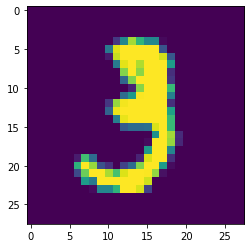

In [96]:
plt.imshow(images[10])
print("The corresponding label: ",labels[10])

In [83]:
sp_intensity, sp_coord, sp_order, superpixels = process_image((images[10], 10, n_images, args, True, True))

print('sp_intensity: {}, sp_coord: {}", "sp_order": {}, "superpixels: {}'.format(len(sp_intensity), len(sp_coord), len(sp_order), len(superpixels)))

image=11/60000, shape=(28, 28, 1), min=0.00, max=1.00, n_sp=70
sp_intensity: 70, sp_coord: 70", "sp_order": 70, "superpixels: 28


In [80]:
print("super_pixel size: ",superpixels.size)
print("image_size: ",images[10].size)

super_pixel size:  784
image_size:  784


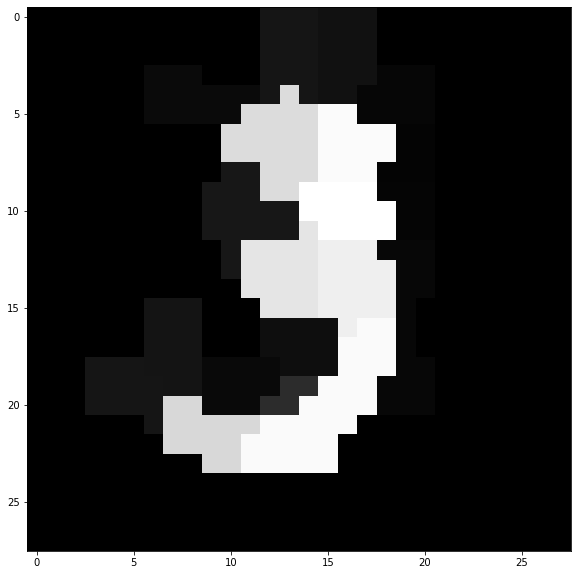

In [81]:
color_label = color.label2rgb(superpixels, image=images[10],kind='avg')
show_image(color_label)

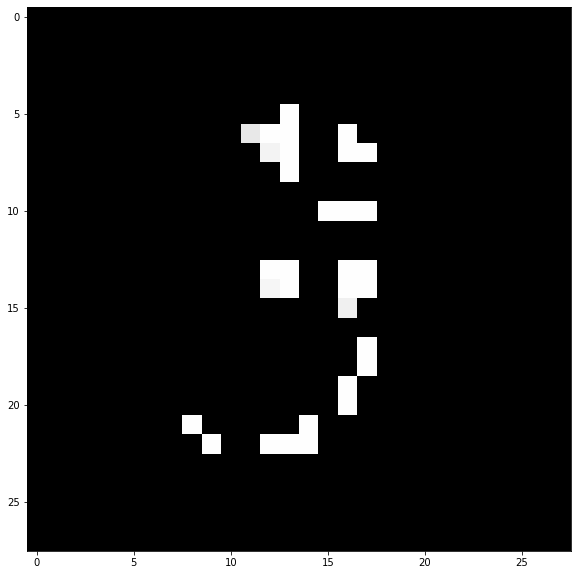

In [82]:
border_image = segmentation.mark_boundaries(images[10], superpixels, (0, 0, 0))
show_image(border_image)

In [84]:
rag_slic = future.graph.rag_mean_color(images[10], superpixels)

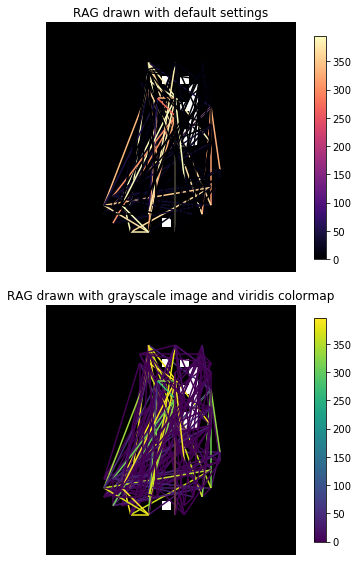

In [95]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))
ax[0].set_title('RAG drawn with default settings')
lc = future.graph.show_rag(images[10], rag_slic, images[10], ax=ax[0])
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax[0])

ax[1].set_title('RAG drawn with grayscale image and viridis colormap')
lc = future.graph.show_rag(images[10], rag_slic, images[10],
                    img_cmap='gray', edge_cmap='viridis', ax=ax[1])
fig.colorbar(lc, fraction=0.03, ax=ax[1])

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

### Visualizing superpixel graphs

In [5]:
import random
from torchvision import transforms, datasets

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np

import dgl
import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

Using backend: pytorch


In [6]:
import os
print("Current working directory: {0}".format(os.getcwd()))
# os.chdir('Graph Neural Network/my_gnn/data')
# os.chdir('../') # go to root folder of the project
print(os.getcwd())

Current working directory: c:\Users\Ronaj.Pradhan\Univeristy of South Dakota\Graph Neural Network\my_gnn
c:\Users\Ronaj.Pradhan\Univeristy of South Dakota\Graph Neural Network\my_gnn


In [7]:
# After finding the superpixel and each superpixel's intensity, co-ordinates, order we then convert these superpixel 
# images into graphs using the k-nearest-neighbour adjacency matrix, where i and j are the co-ordinates of superpixel
# and sigma is the scale parameter defined as the average distance d of the k-nearest neighbours for each node.


def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)
    
    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)
        
    # Convert to symmetric matrix
    A = 0.5 * (A + A.T)
    #A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:   
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d

In [27]:
class MNISTSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 split,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        self.split = split
        self.is_test = split.lower() in ['test', 'val']
        with open(os.path.join(data_dir, 'mnist_75sp_%s.pkl' % split), 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 28

    def precompute_graph_images(self):
        print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]
            
            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features
            
            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

In [29]:
use_feat_for_graph_construct = True
tt = time.time()
data_with_feat_knn = MNISTSuperPix("data", 
                             #split='test', 
                             split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 134.6475s


In [33]:
use_feat_for_graph_construct = False
tt = time.time()
data_no_feat_knn = MNISTSuperPix("data", 
                             #split='test', 
                             split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_no_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 18.9763s


 17%|█▋        | 1687552/9912422 [00:00<00:00, 16791026.50it/s]

9920512it [00:01, 9210857.43it/s]                              


Extracting PATH\MNIST\raw\train-images-idx3-ubyte.gz to PATH\MNIST\raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 114516.52it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH\MNIST\raw\train-labels-idx1-ubyte.gz to PATH\MNIST\raw


1654784it [00:00, 2569406.99it/s]                           


Extracting PATH\MNIST\raw\t10k-images-idx3-ubyte.gz to PATH\MNIST\raw


8192it [00:00, 245300.55it/s]


c:\Users\Ronaj.Pradhan\AppData\Local\miniconda3\envs\benchmark_gnn\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting PATH\MNIST\raw\t10k-labels-idx1-ubyte.gz to PATH\MNIST\raw
Processing...
Done!


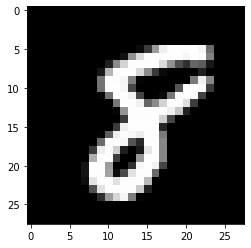

In [25]:
dataset = datasets.MNIST(root='PATH', train=True, download=True, transform=transforms.ToTensor())

x, _ = dataset[777] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

In [30]:
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams

def plot_superpixels_graph(plt, sp_data, adj_matrix, label, feat_coord, with_edges):
    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    intensities = sp_data[0].reshape(-1)

    G = nx.from_numpy_matrix(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree
    
    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
    title = "Label: " + str(label)
    if feat_coord:
        title += " | Using feat and coord for knn"
    else:
        title += " | Using only coord for knn"
    if not with_edges:
        title = "Label: " + str(label) + " | Only superpixel nodes"
    
    plt.title.set_text(title)
    
def show_image(plt, idx, alpha):
    x, label = dataset[idx] # x is now a torch.Tensor
    img = x.numpy()[0]
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title.set_text("Label: " + str(label) + " | Original Image")

c:\Users\Ronaj.Pradhan\AppData\Local\miniconda3\envs\benchmark_gnn\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
c:\Users\Ronaj.Pradhan\AppData\Local\miniconda3\envs\benchmark_gnn\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


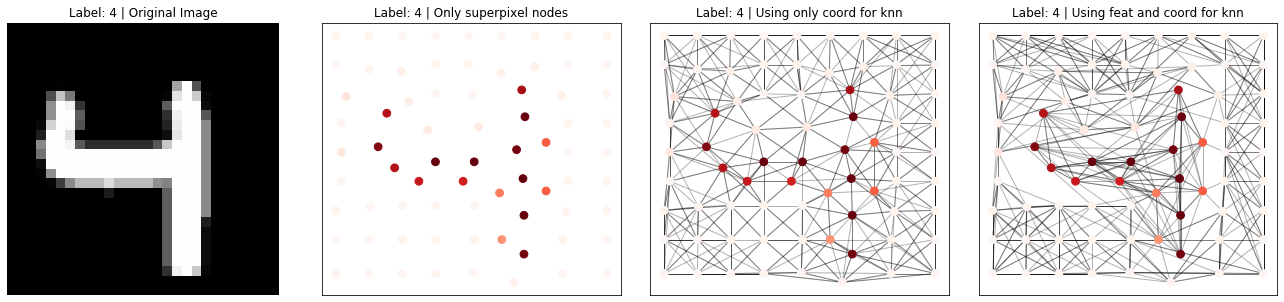

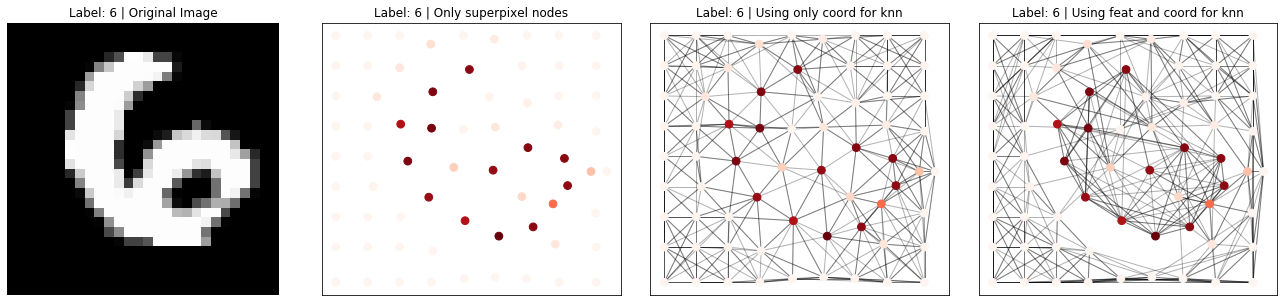

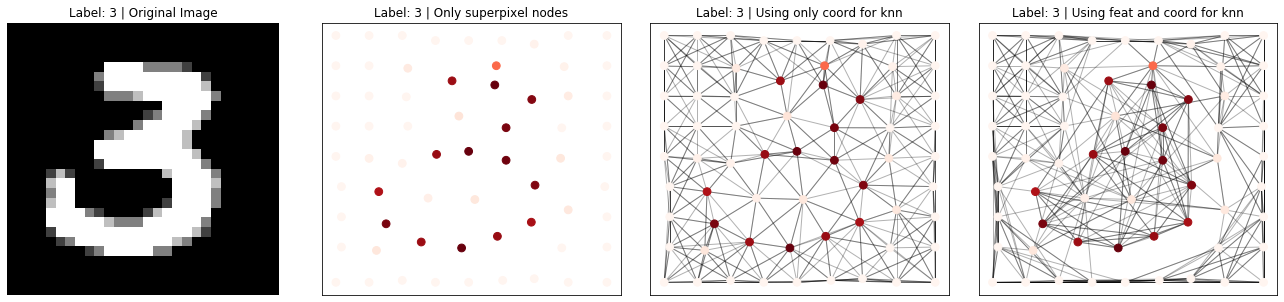

In [34]:
num_samples_plot = 3
for f_idx, idx in enumerate(np.random.choice(int(len(data_no_feat_knn)/2), num_samples_plot, replace=False)):
    f = plt.figure(f_idx, figsize=(23, 5))
    plt1 = f.add_subplot(141)
    show_image(plt1, idx, alpha=0.5)

    plt2 = f.add_subplot(142)  
    plot_superpixels_graph(plt2, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=False)

    plt3 = f.add_subplot(143)
    plot_superpixels_graph(plt3, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt4 = f.add_subplot(144)
    plot_superpixels_graph(plt4, data_with_feat_knn.sp_data[idx],
                           data_with_feat_knn.Adj_matrices[idx],
                           data_with_feat_knn[idx][1],
                           data_with_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    # f.savefig('visualization/mnist_superpix_'+str(idx)+'.jpg')
    plt.show()

In [15]:
args = parse_args()
is_train = args.split.lower() == 'train'
data = datasets.MNIST(args.data_dir, train=is_train, download=False)


dataset mnist
data_dir ./data
out_dir ./data
split train
threads 0
n_sp 75
compactness 0.25
seed 111


In [22]:
data[1][1]

0